<a href="https://colab.research.google.com/github/Soedirman-Machine-Learning/face-mask-detection/blob/main/Face_Mask_Detection_MobileNetV2%2BResNet10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Face Mask Detection**

Program Machine Learning untuk mendeteksi penggunaan masker. Program dibuat menggunakan metode CNN dengan arsitektur MobileNetV2 dan caffe model ResNet-10 untuk face detection.

In [1]:
!nvidia-smi

Thu Dec 10 15:11:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Memeriksa CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


## Tahap Awal

In [4]:
# Melakukan cloning data
!git clone https://github.com/Soedirman-Machine-Learning/face-mask-detection.git

Cloning into 'face-mask-detection'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 3810 (delta 19), reused 11 (delta 3), pack-reused 3769
Receiving objects: 100% (3810/3810), 156.55 MiB | 40.55 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [5]:
# Berpindah ke folder face-mask-detection
%cd face-mask-detection/

# Memeriksa isi folder face-mask-detection
!ls

/content/face-mask-detection
'berkas tugas akhir'
 dataset
 face-detector.zip
'Face Mask Detection MobileNetV2 + MTCNN.ipynb'
'Face Mask Detection VGG16-Net + MTCNN.ipynb'
 Face_Mask_Detection_VGG16Net+ResNet10.ipynb
 README.md


**Face-detector.zip** merupakan file untuk melakukan pengujian model dengan menggunakan res10_300x300_ssd_iter_140000.caffemodel dan deploy.prototxt untuk mendeteksi bagian wajah

In [6]:
# Melakukan unzip pada folder face-detector.zip
!unzip face-detector.zip

Archive:  face-detector.zip
  inflating: deploy.prototxt         
  inflating: example_img/ex1.jpg     
  inflating: example_img/ex2.jpg     
  inflating: example_img/ex3.jpg     
  inflating: example_img/ex4.jpg     
  inflating: example_img/ex5.jpg     
  inflating: example_img/ex6.jpg     
  inflating: example_img/ex7.jpg     
  inflating: example_img/ex8.jpeg    
  inflating: res10_300x300_ssd_iter_140000.caffemodel  


## Mengimpor Libraries yang dibutuhkan

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import argparse
import os
 
# Mengihitung waktu lamanya eksekusi tiap sel di Google Colab
!pip install ipython-autotime
 
%load_ext autotime

time: 126 µs


## Menampilkan Versi TensorFlow yang digunakan

In [8]:
print(tf.__version__)

2.3.0
time: 920 µs


## Preprocessing Datasets

In [9]:
# Inisialisasi nilai Initial Learning Rate, berapa banyak Epoch pelatihan, dan Batch Size
INIT_LR = 1e-4
EPOCHS = 25
BS = 32
 
# Mengambil gambar dari dataset directory, kemudian inisialisasi data dan class gambar
print("Menginput gambar...")
imagePaths = list(paths.list_images('dataset'))
data = []
labels = []
 
# Melakukan eprulangan pada image paths
for imagePath in imagePaths:
 
    # Mengekstrak class label dari filename
    label = imagePath.split(os.path.sep)[-2]
    # Memuat input gambar (224x224) dan melakukan proses
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
 
    # Mengupdate data dan labels lists, berurutan
    data.append(image)
    labels.append(label)
 
# Mengkonversi data dan label ke dalam NumPy Arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)
 
# Melakukan one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

Menginput gambar...


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


time: 16 s


### Membuat objek ImageDataGenerator dan Data Augmentation

In [10]:
# Mempartisi data ke dalam pelatihan dan pengujian ( 75% : 25% )
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)
 
# Membentuk training image generator untuk data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

time: 674 ms


## Membuat Model Jaringan CNN yang sudah dipelajari sebelumnya (pre-trained convnets)

In [11]:
# Arsitektur jaringan MobileNetV2
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 0s 0us/step
time: 6.7 s


### Feature Extraction

In [12]:
baseModel.trainable = False
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

## Tahap Pembuatan Model

In [13]:
# Membentuk bagian head dari model yang akan ditempatkan pada base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
 
# Menempatkan head model pada base model
model = Model(inputs=baseModel.input, outputs=headModel)
 
# Perulangan pada seluruh base model
for layer in baseModel.layers:
    layer.trainable = False
 
# Persiapan kompilasi model
print("Mengkompilasi model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

model.summary()

Mengkompilasi model...
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
________________________________________________________________

### Melakukan Pelatihan Model

In [14]:
# Pelatihan model
print("Training head model...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Training head model...
Epoch 1/25
95/95 [==============================] - 31s 323ms/step - loss: 0.3973 - accuracy: 0.8164 - val_loss: 0.1338 - val_accuracy: 0.9635
Epoch 2/25
95/95 [==============================] - 30s 314ms/step - loss: 0.1308 - accuracy: 0.9552 - val_loss: 0.0770 - val_accuracy: 0.9804
Epoch 3/25
95/95 [==============================] - 30s 313ms/step - loss: 0.0860 - accuracy: 0.9730 - val_loss: 0.0537 - val_accuracy: 0.9857
Epoch 4/25
95/95 [==============================] - 30s 314ms/step - loss: 0.0611 - accuracy: 0.9756 - val_loss: 0.0435 - val_accuracy: 0.9896
Epoch 5/25
95/95 [==============================] - 30s 318ms/step - loss: 0.0588 - accuracy: 0.9796 - val_loss: 0.0375 - val_accuracy: 0.9948
Epoch 6/25
95/95 [==============================] - 30s 316ms/step - loss: 0.0495 - accuracy: 0.9829 - val_loss: 0.0328 - val_accuracy: 0.9922
Epoch 7/25
95/95 [==============================] - 30s 315ms/step - loss: 0.0475 - accuracy: 0.9819 - val_loss: 0.0312

## Menampilkan Grafik Model Hasil Pelatihan

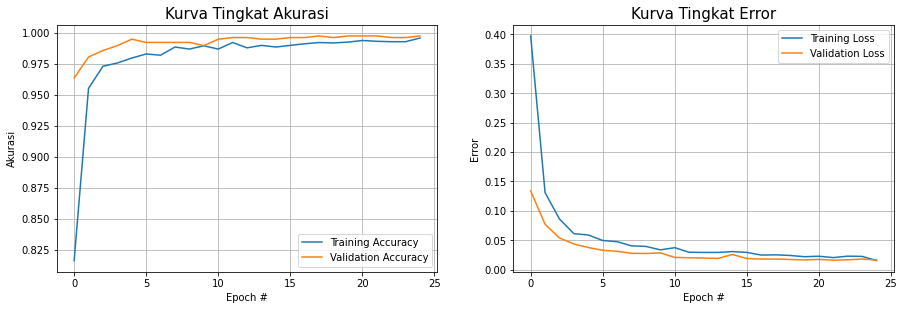

time: 334 ms


In [15]:
N = EPOCHS
fig = plt.figure(figsize=(7, 4))
fig.set_figheight(10)
fig.set_figwidth(15)
 
plt.subplot(2, 2, 1)
plt.plot(np.arange(0, N), H.history["accuracy"],label = "Training Accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"],label = "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Akurasi")
plt.title("Kurva Tingkat Akurasi", size=15)
plt.grid(zorder = 0)
 
plt.subplot(2, 2, 2)
plt.plot(np.arange(0, N), H.history["loss"],label = "Training Loss")
plt.plot(np.arange(0, N), H.history["val_loss"],label = "Validation Loss")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Error")
plt.title("Kurva Tingkat Error", size=15)
plt.grid(zorder = 0)
plt.show()

In [16]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4
time: 2.11 ms


## Evaluasi Jaringan

In [17]:
# Membuat prediksi dari pengujian
predIdxs = model.predict(testX, batch_size=BS)
 
# Untuk setiap gambar dalam set pengujian, kita perlu menemukan indeks label
# dengan probabilitas prediksi terbesar
predIdxs = np.argmax(predIdxs, axis=1)
 
# Menampilkan laporan klasifikasi yang diformat dengan baik
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       1.00      0.99      1.00       383
without_mask       0.99      1.00      1.00       384

    accuracy                           1.00       767
   macro avg       1.00      1.00      1.00       767
weighted avg       1.00      1.00      1.00       767

time: 1.71 s


## Menyimpan dan Konversi Model ke ".tflite"
Menyimpan model menggunakan tf.saved_model/save dan kemudian mengkonversi model tersimpan ke format yang kompatibel tf lite.

In [18]:
export_dir='saved_model/1'
tf.saved_model.save(model, export_dir)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/1/assets
time: 14.8 s


In [19]:
# Mengkonvert model ke format tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

time: 7.2 s


In [20]:
# Menyimpan model
tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

9544552

time: 10.3 ms


In [21]:
# Memuat model dan mengalokasikan ke tensor
interpreter = tf.lite.Interpreter(model_content = tflite_model)
interpreter.allocate_tensors()

# Mendapatkan input dan ouput tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']

print(input_details)
print(output_details)

[{'name': 'input_1', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'Identity', 'index': 182, 'shape': array([1, 2], dtype=int32), 'shape_signature': array([-1,  2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
time: 26.6 ms


# Pengujian Model

Model diujikan pada gambar dan secara real-time dengan menggunakan res10_300x300_ssd_iter_14000.caffemodel dan deploy.prototxt yang digunakan untuk mendeteksi wajah.

## Penggunaan Model pada Gambar


In [22]:
import cv2
from google.colab.patches import cv2_imshow

time: 4.92 ms


Mendeteksi wajah...


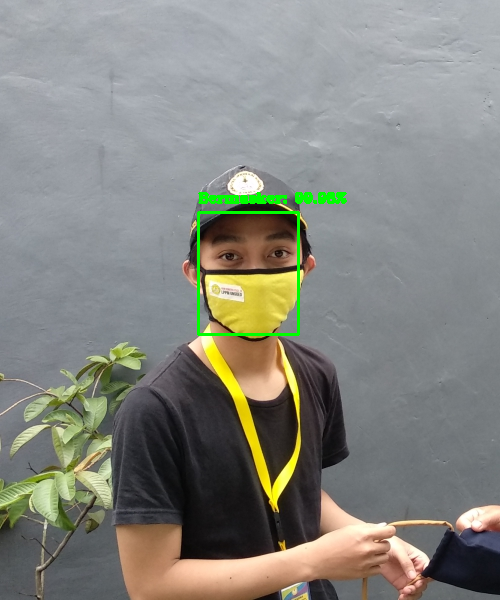

-1

time: 796 ms


In [23]:
image = cv2.imread('/content/face-mask-detection/example_img/ex3.jpg')
orig = image.copy()
(h, w) = image.shape[:2]

blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
	(104.0, 177.0, 123.0))

net=cv2.dnn.readNet('/content/face-mask-detection/deploy.prototxt','/content/face-mask-detection/res10_300x300_ssd_iter_140000.caffemodel')

# Melewatkan blob melalui jaringan dan mendapatkan deteksi wajah
print("Mendeteksi wajah...")
net.setInput(blob)
detections = net.forward()

for i in range(0, detections.shape[2]):
	# ekstrak keyakinan (yaitu, probabilitas) yang terkait dengan deteksi
	confidence = detections[0, 0, i, 2]

	if confidence > 0.5:
		# Menghitung koordinat (x, y) dari kotak pembatas untuk objek
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")

		# Memastikan kotak pembatas berada dalam dimensi bingkai
		(startX, startY) = (max(0, startX), max(0, startY))
		(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

		# Ekstrak ROI wajah, konversikan dari BGR ke pemesanan saluran RGB,
    # dan mengubah ukurannya menjadi 224x224, dan lalu pre-proses
		face = image[startY:endY, startX:endX]
		face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
		face = cv2.resize(face, (224, 224))
		face = img_to_array(face)
		face = preprocess_input(face)
		face = np.expand_dims(face, axis=0)

		# Membaca wajah dengan model
		(mask, withoutMask) = model.predict(face)[0]

		# Menggunakan masker hijau, tidak bermasker merah
		label = "Bermasker" if mask > withoutMask else "Tidak Bermasker"
		color = (0, 255, 0) if label == "Bermasker" else (0, 0, 255)

		# Probabilitas hasil deteksi
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# Menampilkan hasil dengan label dan kotak
		cv2.putText(image, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_TRIPLEX, 0.45, color, 2)
		cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

# Menampilkan output
cv2_imshow(image)
cv2.waitKey(0)

## Menguji Model Secara Realtime

In [24]:
# Mengimport lib
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time
import cv2
import os
 
def detect_and_predict_mask(frame, faceNet, maskNet):
    # Membuat dimensi kotak deteksi
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
        (104.0, 177.0, 123.0))
 
    # Melewatkan blob dan mendeteksi wajah
    faceNet.setInput(blob)
    detections = faceNet.forward()
 
    # Inisialisasi
    faces = []
    locs = []
    preds = []
 
    for i in range(0, detections.shape[2]):
        # ekstrak keyakinan (yaitu, probabilitas) yang terkait dengan deteksi
        confidence = detections[0, 0, i, 2]
 
        if confidence > 0.5:
            # Menghitung koordinat (x, y) dari kotak pembatas untuk objek
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
 
            # Memastikan kotak pembatas berada dalam dimensi bingkai
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
 
            # Ekstrak ROI wajah, konversikan dari BGR ke pemesanan saluran RGB,
            # dan mengubah ukurannya menjadi 224x224, dan lalu pre-proses
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
 
            # Menambahkan kotak deteksi
            faces.append(face)
            locs.append((startX, startY, endX, endY))
 
    if len(faces) > 0:
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size=32)
 
    return (locs, preds)
 
faceNet=cv2.dnn.readNet('/content/face-mask-detection/deploy.prototxt','/content/face-mask-detection/res10_300x300_ssd_iter_140000.caffemodel')

time: 50.2 ms


In [25]:
import base64
import html
import io
import time
 
from IPython.display import display, Javascript
from google.colab.output import eval_js
import numpy as np
from PIL import Image
import cv2
 
def start_input():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }
      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);
      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'Ketika selesai, klik disini atau pada video untuk berhenti dari demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();
      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }
      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')
 
  display(js)
  
def take_photo(label, img_data):
  data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
  return data

time: 28.3 ms


In [26]:
def js_reply_to_image(js_reply):
    """
    input: 
          js_reply: JavaScript object, contain image from webcam
    output: 
          image_array: image array RGB size 512 x 512 from webcam
    """
    jpeg_bytes = base64.b64decode(js_reply['img'].split(',')[1])
    image_PIL = Image.open(io.BytesIO(jpeg_bytes))
    image_array = np.array(image_PIL)
 
    return image_array

time: 4.06 ms


<IPython.core.display.Javascript object>

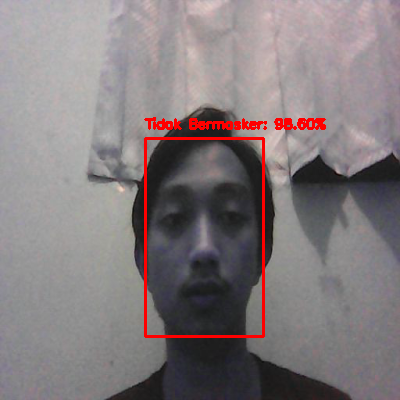

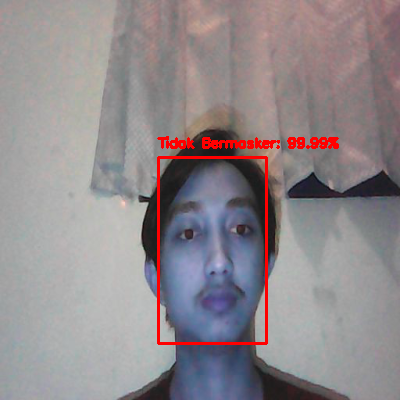

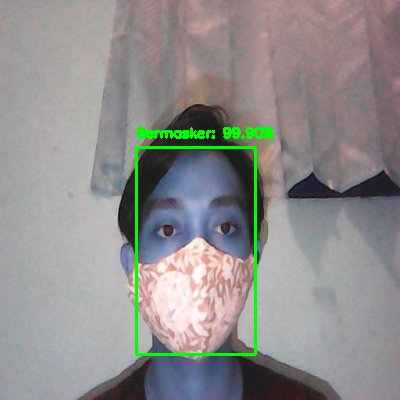

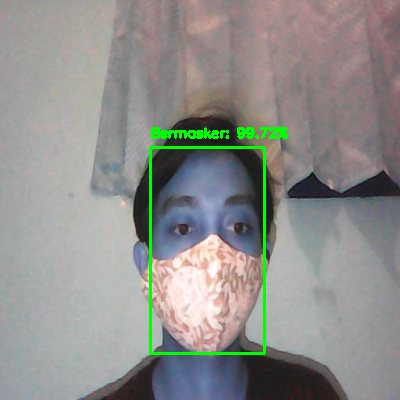

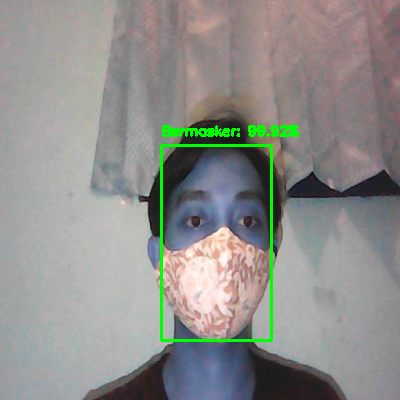

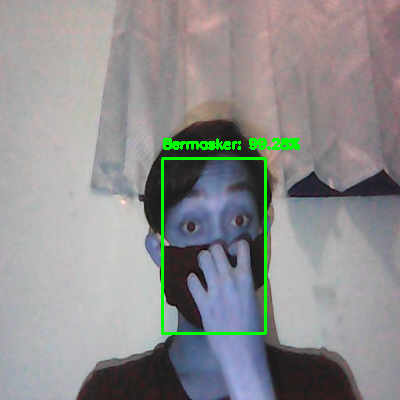

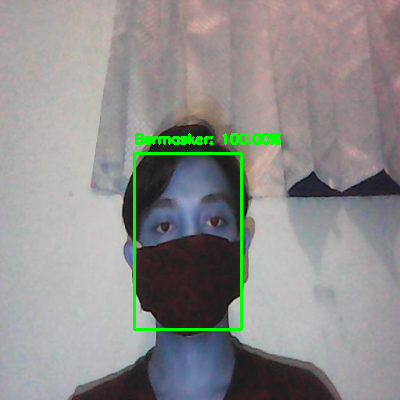

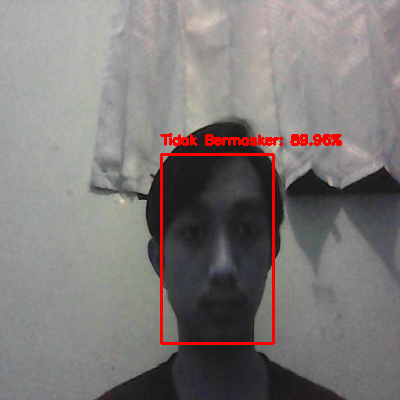

time: 3min 21s


In [27]:
start_input()
label_html = 'Capturing...'
img_data = ''
count = 0 
from google.colab.patches import cv2_imshow
while True:
  js_reply = take_photo(label_html, img_data)
  if not js_reply:
    break
    
  image = js_reply_to_image(js_reply)

	# Mengambil frame dari aliran video berulir dan 
  # ukurannya maksimum lebar 400 pixel
  frame = image
  v=True
  if v == True:

    frame = imutils.resize(frame, width=400)

	# Mendeteksi bermasker atau tidak
    (locs, preds) = detect_and_predict_mask(frame, faceNet, model)
    for (box, pred) in zip(locs, preds):


		# Membuka kotak dan prediksi
      (startX, startY, endX, endY) = box
      (mask, withoutMask) = pred

		# Menggunakan masker hijau, tidak bermasker merah
      label = "Bermasker" if mask > withoutMask else "Tidak Bermasker"
      color = (0, 255, 0) if label == "Bermasker" else (0, 0, 255)

		# Probabilitas pada label
      label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# Menampilkan hasil dengan label dan kotak dari frame
      frame=cv2.putText(frame, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
      frame=cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

	# Menampilkan ouput
      cv2_imshow(frame)